**EXPLORATORY DATA ANALYSIS**

*DOWNLOAD DATASET*

In [3]:
# Install library kaggle
!pip install kaggle

# Download Google Job Skills dataset dari kaggle
!kaggle datasets download -d niyamatalmass/google-job-skills

# Extract the dataset
import zipfile

with zipfile.ZipFile("google-job-skills.zip", 'r') as zip_ref:
    zip_ref.extractall("google_job_skills")

# List extracted files
import os
os.listdir("google_job_skills")


Dataset URL: https://www.kaggle.com/datasets/niyamatalmass/google-job-skills
License(s): CC-BY-NC-SA-4.0
  0% 0.00/407k [00:00<?, ?B/s]
100% 407k/407k [00:00<00:00, 111MB/s]


['job_skills.csv']

---

*IMPORT LIBRARY*

In [4]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import joblib
import string
import ast
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.util import ngrams


# Label encoding and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization #type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #type: ignore


# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity calculation
from scipy.spatial.distance import cosine

# General utilities
import os

# Checking TF version
print(tf. __version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


2.17.1


*IMPORT DATASET*

In [5]:
data = pd.read_csv('/content/google_job_skills/job_skills.csv')

# Menampilkan head dataset
data.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...


*DATA PREPROCESSING*

In [6]:
data.rename(columns={'Category': 'Job'}, inplace=True)

In [7]:
data = data.dropna(axis=0)

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Company                   1235 non-null   object
 1   Title                     1235 non-null   object
 2   Job                       1235 non-null   object
 3   Location                  1235 non-null   object
 4   Responsibilities          1235 non-null   object
 5   Minimum Qualifications    1235 non-null   object
 6   Preferred Qualifications  1235 non-null   object
dtypes: object(7)
memory usage: 77.2+ KB
None


In [9]:
for col in data.select_dtypes(include=['category', 'object']):
    print(f"\nColumn: {col}")
    print(data[col].value_counts())


Column: Company
Company
Google     1212
YouTube      23
Name: count, dtype: int64

Column: Title
Title
Business Intern 2018                                                       35
MBA Intern, Summer 2018                                                    34
MBA Intern 2018                                                            28
BOLD Intern, Summer 2018                                                   21
Field Sales Representative, Google Cloud                                   17
                                                                           ..
Online Sales Account Strategist (Italian)                                   1
Sales Associate, Large Customer Sales                                       1
Associate Account Strategist (Polish), Google Marketing Solutions Sales     1
Business Development Consultant, Google Marketing Solutions (Italian)       1
Facilities Manager                                                          1
Name: count, Length: 779, dtype: int64

In [10]:
# Definisikan fungsi untuk mengelompokkan pekerjaan
def categorize_job(job):
    if job in ['Sales & Account Management', 'Sales Operations', 'Partnerships']:
        return 'Sales and Marketing'
    elif job in ['Finance', 'Business Strategy', 'Program Management']:
        return 'Finance and Business Strategy'
    elif job in ['Software Engineering','IT & Data Management', 'Developer Relations']:
        return 'Software Development and IT Services'
    elif job in ['Hardware Engineering', 'Technical Solutions', 'Technical Infrastructure', 'Network Engineering', 'Data Center & Network']:
        return 'Hardware Engineering and Infrastructure'
    elif job in ['Product & Customer Support', 'Administrative', 'People Operations', 'Manufacturing & Supply Chain','Real Estate & Workplace Services']:
        return 'Operations and Support'
    elif job in ['User Experience & Design', 'Technical Writing']:
        return 'Design and User Experience'
    elif job in ['Legal & Government Relations', 'Marketing & Communications']:
        return 'Legal and Communications'
    else:
        return 'Other'  # Untuk Job yang tidak terkategorisasi

# Menambahkan kolom 'Category'
data['Category'] = data['Job'].apply(categorize_job)

# Meletakkan kolom 'Category' di paling kanan
data = data[[col for col in data.columns if col != 'Category'] + ['Category']]

# Menampilkan beberapa baris untuk memverifikasi
data.head()


,Company,Title,Job,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,Category
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...,Finance and Business Strategy
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin...",Operations and Support
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...,Hardware Engineering and Infrastructure
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,...",Software Development and IT Services
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...,Finance and Business Strategy


*DATA VISUALIZATION*

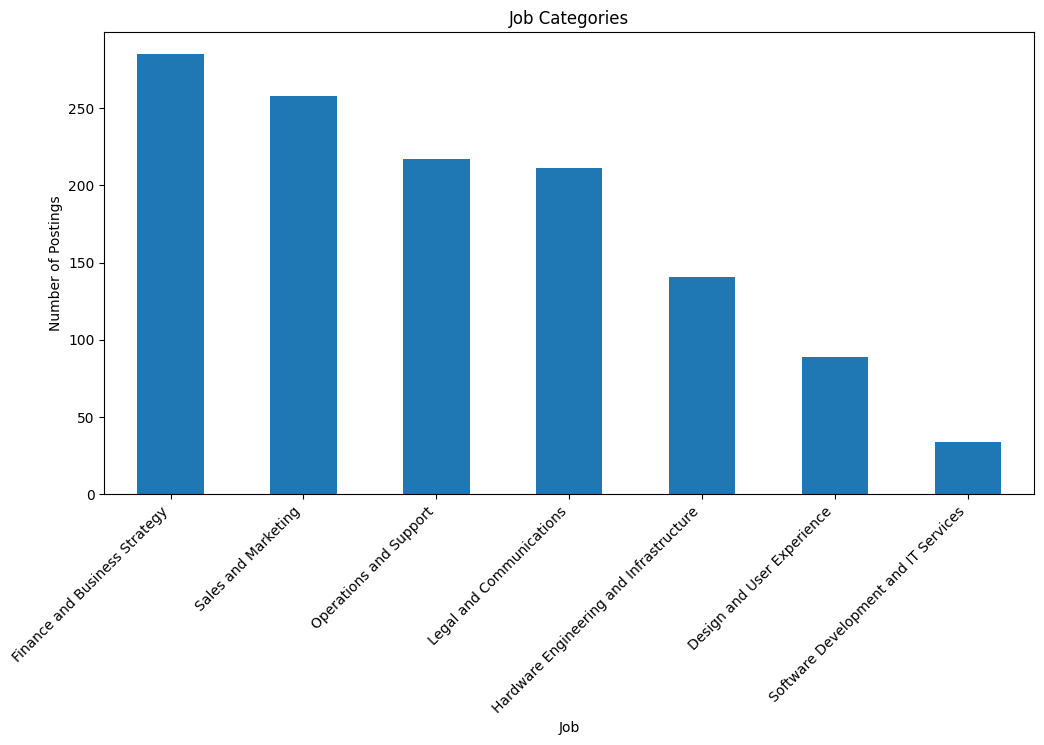

In [11]:
# Distribution of Job Categories
plt.figure(figsize=(12, 6))
data['Category'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Job Categories')
plt.xlabel('Job')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45, ha='right')
plt.show()

*TEXT PROCESSING*

In [12]:
# Function to extract common bigrams from a given text series
def extract_common_bigrams(text_series):
    # Combine all texts into a single string
    combined_text = ' '.join(text_series.dropna())

    # Tokenize and clean the text
    tokens = word_tokenize(combined_text.lower())
    tokens = [word for word in tokens if word not in stopwords.words('english') and word not in string.punctuation]

    # Generate bigrams
    bigrams_list = list(ngrams(tokens, 2))  # Change the number to 3 for trigrams
    bigram_counts = Counter(bigrams_list)

    # Convert tuples back to strings for better readability
    bigram_strings = [' '.join(bigram) for bigram in bigram_counts.keys()]

    return list(zip(bigram_strings, bigram_counts.values()))[:50]  # Get the 10 most common bigrams

# Group by category and extract common bigrams for Responsibilities
common_bigrams_responsibilities = data.groupby('Category')['Responsibilities'].apply(extract_common_bigrams)

# Group by category and extract common bigrams for Preferred Qualifications
common_bigrams_qualifications = data.groupby('Category')['Preferred Qualifications'].apply(extract_common_bigrams)

# Convert the results to a DataFrame for better readability
common_bigrams_responsibilities_df = common_bigrams_responsibilities.reset_index()
common_bigrams_qualifications_df = common_bigrams_qualifications.reset_index()

pd.set_option('display.max_colwidth', None)

In [13]:
common_bigrams_responsibilities_df['Responsibilities'] = common_bigrams_responsibilities_df['Responsibilities'].apply(str)
common_bigrams_responsibilities_df

,Category,Responsibilities
0,Design and User Experience,"[('write technical', 5), ('technical documentation', 5), ('documentation external', 5), ('external developer', 5), ('developer audience', 5), ('audience api', 5), ('api reference', 5), ('reference docs', 5), ('docs developer', 5), ('developer guides', 5), ('guides design', 5), ('design organize', 5), ('organize documentation', 5), ('documentation sets', 5), ('sets new', 5), ('new apis', 5), ('apis developer', 5), ('developer products', 5), ('products edit', 5), ('edit clarify', 5), ('clarify proofread', 5), ('proofread documents', 5), ('documents written', 5), ('written others', 5), ('others coach', 5), ('coach non-writers', 5), ('non-writers ways', 5), ('ways improve', 5), ('improve writing', 9), ('writing skills', 5), ('skills supplement', 5), ('supplement developer', 5), ('developer documentation', 5), ('documentation relevant', 5), ('relevant sample', 5), ('sample code', 5), ('code write', 4), ('code project', 1), ('project manage', 1), ('manage various', 1), ('various research', 1), ('research projects', 1), ('projects working', 1), ('working closely', 1), ('closely cross-functional', 1), ('cross-functional internal', 1), ('internal teams', 1), ('teams design', 1), ('design strategy', 1), ('strategy industrial', 1)]"
1,Finance and Business Strategy,"[('shape shepherd', 1), ('shepherd ship', 1), ('ship show', 1), ('show technical', 1), ('technical programs', 1), ('programs designed', 1), ('designed support', 1), ('support work', 1), ('work cloud', 3), ('cloud customer', 1), ('customer engineers', 1), ('engineers solutions', 1), ('solutions architects', 1), ('architects measure', 1), ('measure report', 1), ('report key', 2), ('key metrics', 4), ('metrics tied', 1), ('tied programs', 1), ('programs identify', 1), ('identify need', 1), ('need change', 1), ('change course', 1), ('course cancel', 1), ('cancel scale', 1), ('scale programs', 1), ('programs regional', 1), ('regional global', 3), ('global platform', 1), ('platform communicate', 1), ('communicate status', 1), ('status identify', 1), ('identify obstacles', 1), ('obstacles paths', 1), ('paths resolution', 1), ('resolution stakeholders', 1), ('stakeholders including', 1), ('including senior', 2), ('senior roles', 1), ('roles transparent', 1), ('transparent regular', 1), ('regular professional', 1), ('professional timely', 1), ('timely manner', 4), ('manner establish', 1), ('establish expectations', 1), ('expectations rationale', 1), ('rationale deliverables', 1), ('deliverables stakeholders', 1), ('stakeholders program', 1)]"
2,Hardware Engineering and Infrastructure,"[('collect analyze', 3), ('analyze data', 3), ('data draw', 1), ('draw insight', 1), ('insight identify', 1), ('identify strategic', 1), ('strategic solutions', 1), ('solutions build', 1), ('build consensus', 2), ('consensus facilitating', 1), ('facilitating broad', 1), ('broad collaboration', 1), ('collaboration clear', 1), ('clear communication', 1), ('communication documentation', 1), ('documentation work', 1), ('work cross-functional', 2), ('cross-functional stakeholders', 1), ('stakeholders gather', 1), ('gather requirements', 1), ('requirements manage', 1), ('manage implementation', 1), ('implementation drive', 1), ('drive delivery', 1), ('delivery projects', 1), ('projects communicate', 1), ('communicate customers', 4), ('customers via', 3), ('via phone', 4), ('phone email', 4), ('email provide', 4), ('provide strategic', 6), ('strategic advice', 5), ('advice consultation', 2), ('consultation help', 2), ('help advertisers', 4), ('advertisers get', 4), ('get best', 4), ('best experience', 4), ('experience advertising', 3), ('advertising products', 4), ('products implement', 2), ('implement creative', 5), ('creative ways', 5), ('ways improve', 11), ('improve customer', 6), ('customer relationships', 4), ('relationships tailor', 4), ('tailor share', 4), ('share online', 4)]"
3,Legal and Communications,"[('develop write', 8), ('write edit', 8), (

In [14]:
common_bigrams_qualifications_df['Preferred Qualifications'] = common_bigrams_qualifications_df['Preferred Qualifications'].apply(str)
common_bigrams_qualifications_df

,Category,Preferred Qualifications
0,Design and User Experience,"[('graduating ba/bs', 5), ('ba/bs degree', 5), ('degree ma/ms', 5), ('ma/ms degree', 11), ('degree 2018.', 5), ('2018. familiarity', 5), ('familiarity source', 5), ('source code', 5), ('code management', 5), ('management build', 5), ('build systems', 5), ('systems related', 5), ('related processes', 5), ('processes ability', 5), ('ability quickly', 5), ('quickly learn', 5), ('learn use', 5), ('use technology', 5), ('technology proficiency', 5), ('proficiency html', 5), ('html css', 13), ('css unix', 5), ('unix environment', 6), ('environment ability', 7), ('ability manage', 9), ('manage multiple', 9), ('multiple competing', 9), ('competing priorities', 9), ('priorities fast-paced', 9), ('fast-paced constantly', 9), ('constantly changing', 9), ('changing environment', 9), ('environment graduating', 4), ('environment experience', 3), ('experience hardware', 1), ('hardware research', 1), ('research thorough', 1), ('thorough knowledge', 1), ('knowledge user', 1), ('user centered', 1), ('centered design', 1), ('design processes', 1), ('processes iterative', 1), ('iterative development', 1), ('development processes', 1), ('processes proven', 1), ('proven ability', 5), ('ability multitask', 1), ('multitask analyze', 1), ('analyze opportunities', 1)]"
1,Finance and Business Strategy,"[('experience business', 1), ('business technology', 3), ('technology market', 1), ('market program', 1), ('program manager', 1), ('manager saas', 1), ('saas cloud', 2), ('cloud computing', 3), ('computing and/or', 1), ('and/or emerging', 1), ('emerging technologies', 7), ('technologies significant', 1), ('significant cross-functional', 1), ('cross-functional experience', 1), ('experience across', 1), ('across engineering', 1), ('engineering sales', 1), ('sales marketing', 5), ('marketing teams', 2), ('teams cloud', 1), ('computing related', 1), ('related technical', 1), ('technical fields', 1), ('fields proven', 1), ('proven successful', 1), ('successful program', 1), ('program outcomes', 1), ('outcomes idea', 2), ('idea launch', 1), ('launch multiple', 1), ('multiple contexts', 2), ('contexts throughout', 1), ('throughout career', 1), ('career ability', 1), ('ability manage', 17), ('manage expectations', 1), ('expectations demands', 1), ('demands priorities', 1), ('priorities multiple', 1), ('multiple internal', 1), ('internal stakeholders', 1), ('stakeholders based', 1), ('based overarching', 1), ('overarching vision', 1), ('vision success', 1), ('success global', 1), ('global team', 3), ('team health', 1), ('health ability', 1), ('ability work', 71)]"
2,Hardware Engineering and Infrastructure,"[('experience partnering', 1), ('partnering consulting', 1), ('consulting cross-functionally', 1), ('cross-functionally senior', 1), ('senior stakeholders', 1), ('stakeholders proficiency', 1), ('proficiency database', 1), ('database query', 1), ('query language', 1), ('language e.g', 1), ('e.g sql', 1), ('sql ability', 1), ('ability manage', 4), ('manage multiple', 9), ('multiple projects', 7), ('projects ambiguous', 1), ('ambiguous environment', 1), ('environment strong', 1), ('strong presentation', 1), ('presentation communication', 2), ('communication skills', 30), ('skills ability', 19), ('ability communicate', 11), ('communicate statistical', 1), ('statistical concepts', 1), ('concepts explain', 1), ('explain recommendations', 1), ('recommendations non-experts', 1), ('non-experts experience', 1), ('experience sales', 6), ('sales customer', 3), ('customer service', 9), ('service account', 3), ('account management', 7), ('management marketing', 3), ('marketing consulting', 3), ('consulting experience', 2), ('experience managing', 21), ('managing customizing', 4), ('customizing experience', 4), ('experience specific', 3), ('specific customer', 3), ('customer base', 4), ('base experience', 2), ('experience leading', 5), ('leading motivating', 4), ('motivating working', 4), ('working effectively',

TEXT VECTORIZATION

In [15]:
# Define a function to preprocess text for vectorization
def preprocess_text(text_series):
    # Combine all texts into a single string
    text_series = text_series.fillna('')  # Handle NaN values
    return text_series.str.lower().str.replace('[{}]'.format(string.punctuation), '')

# Preprocess the text columns
common_bigrams_responsibilities_df['Responsibilities'] = preprocess_text(common_bigrams_responsibilities_df['Responsibilities'])
common_bigrams_qualifications_df['Preferred Qualifications'] = preprocess_text(common_bigrams_qualifications_df['Preferred Qualifications'])

# Ensure both DataFrames have the same index as the main DataFrame
common_bigrams_responsibilities_df = common_bigrams_responsibilities_df.set_index('Category')
common_bigrams_qualifications_df = common_bigrams_qualifications_df.set_index('Category')

# Combine Responsibilities and Preferred Qualifications into a single column for vectorization,
# using the index of the main DataFrame for alignment.
data['Combined Text'] = data['Category'].map(common_bigrams_responsibilities_df['Responsibilities']) + " " + data['Category'].map(common_bigrams_qualifications_df['Preferred Qualifications'])

# Handle potential NaN values after combining:
data['Combined Text'] = data['Combined Text'].fillna('')

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # Limit to 5000 features
X_tfidf = tfidf_vectorizer.fit_transform(data['Combined Text'])

# Convert the sparse matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the first few rows of the vectorized DataFrame
print(tfidf_df.head())

# Encode the categories as labels
label_encoder = LabelEncoder()
data['Category Encoded'] = label_encoder.fit_transform(data['Category'])

# Splitting into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, data['Category Encoded'], test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

         10        11   12   13        14   15   16        17        18  \
0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.039223  0.000000   
1  0.032243  0.020343  0.0  0.0  0.061229  0.0  0.0  0.000000  0.030615   
2  0.000000  0.046851  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
3  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
4  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.039223  0.000000   

         19  ...   vision      ways      web      work   working  write  \
0  0.000000  ...  0.10113  0.000000  0.00000  0.079088  0.000000    0.0   
1  0.000000  ...  0.00000  0.000000  0.00000  0.000000  0.000000    0.0   
2  0.040648  ...  0.00000  0.096595  0.00000  0.046344  0.054883    0.0   
3  0.000000  ...  0.00000  0.000000  0.32303  0.045452  0.071770    0.0   
4  0.000000  ...  0.10113  0.000000  0.00000  0.079088  0.000000    0.0   

   writers  writing  written  years  
0      0.0      0.0      0.0    0.0  
1      0.0      0.0   

In [16]:
# Check the first few rows of preprocessed text
data[['Responsibilities', 'Preferred Qualifications', 'Combined Text']].head()

,Responsibilities,Preferred Qualifications,Combined Text
0,"Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expectations and rationale on deliverables for stakeholders and program contributors.\nProvide program performance feedback to teams in Product, Engineering, Sales, and Marketing (among others) to enable efficient cross-team operations.","Experience in the business technology market as a program manager in SaaS, cloud computing, and/or emerging technologies.\nSignificant cross-functional experience across engineering, sales, and marketing teams in cloud computing or related technical fields.\nProven successful program outcomes from idea to launch in multiple contexts throughout your career.\nAbility to manage the expectations, demands and priorities of multiple internal stakeholders based on overarching vision and success for global team health.\nAbility to work under pressure and possess flexibility with changing needs and direction in a rapidly-growing organization.\nStrong organization and communication skills.","[('shape shepherd', 1), ('shepherd ship', 1), ('ship show', 1), ('show technical', 1), ('technical programs', 1), ('programs designed', 1), ('designed support', 1), ('support work', 1), ('work cloud', 3), ('cloud customer', 1), ('customer engineers', 1), ('engineers solutions', 1), ('solutions architects', 1), ('architects measure', 1), ('measure report', 1), ('report key', 2), ('key metrics', 4), ('metrics tied', 1), ('tied programs', 1), ('programs identify', 1), ('identify need', 1), ('need change', 1), ('change course', 1), ('course cancel', 1), ('cancel scale', 1), ('scale programs', 1), ('programs regional', 1), ('regional global', 3), ('global platform', 1), ('platform communicate', 1), ('communicate status', 1), ('status identify', 1), ('identify obstacles', 1), ('obstacles paths', 1), ('paths resolution', 1), ('resolution stakeholders', 1), ('stakeholders including', 1), ('including senior', 2), ('senior roles', 1), ('roles transparent', 1), ('transparent regular', 1), ('regular professional', 1), ('professional timely', 1), ('timely manner', 4), ('manner establish', 1), ('establish expectations', 1), ('expectations rationale', 1), ('rationale deliverables', 1), ('deliverables stakeholders', 1), ('stakeholders program', 1)] [('experience business', 1), ('business technology', 3), ('technology market', 1), ('market program', 1), ('program manager', 1), ('manager saas', 1), ('saas cloud', 2), ('cloud computing', 3), ('computing and/or', 1), ('and/or emerging', 1), ('emerging technologies', 7), ('technologies significant', 1), ('significant cross-functional', 1), ('cross-functional experience', 1), ('experience across', 1), ('across engineering', 1), ('engineering sales', 1), ('sales marketing', 5), ('marketing teams', 2), ('teams cloud', 1), ('computing related', 1), ('related technical', 1), ('technical fields', 1), ('fields proven', 1), ('proven successful', 1), ('successful program', 1), ('program outcomes', 1), ('outcomes idea', 2), ('idea launch', 1), ('launch multiple', 1), ('multiple contexts', 2), ('contexts throughout', 1), ('throughout career', 1), ('career ability', 1), ('ability manage', 17), ('manage expectations', 1), ('expectations demands', 1), ('demands priorities', 1), ('priorities multiple', 1), ('multiple internal', 1), ('internal stakeholders', 1), ('stakeholders based', 1), ('based overarching', 1), ('overarching vision', 1), ('vision success', 1), ('success global', 1), ('global team', 3), ('team health', 1), ('health ability', 1), ('ability work'

In [17]:
# Check the shape of the TF-IDF matrix
print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df.head())

# Display the vocabulary (top 10 terms)
print(f"Top 10 Terms: {tfidf_vectorizer.get_feature_names_out()[:10]}")

TF-IDF Matrix Shape: (1235, 437)
         10        11   12   13        14   15   16        17        18  \
0  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.039223  0.000000   
1  0.032243  0.020343  0.0  0.0  0.061229  0.0  0.0  0.000000  0.030615   
2  0.000000  0.046851  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
3  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000   
4  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.0  0.039223  0.000000   

         19  ...   vision      ways      web      work   working  write  \
0  0.000000  ...  0.10113  0.000000  0.00000  0.079088  0.000000    0.0   
1  0.000000  ...  0.00000  0.000000  0.00000  0.000000  0.000000    0.0   
2  0.040648  ...  0.00000  0.096595  0.00000  0.046344  0.054883    0.0   
3  0.000000  ...  0.00000  0.000000  0.32303  0.045452  0.071770    0.0   
4  0.000000  ...  0.10113  0.000000  0.00000  0.079088  0.000000    0.0   

   writers  writing  written  years  
0      0.0      0.0      0.

In [18]:
# Check unique labels and their encoding
print(f"Unique Categories: {data['Category'].unique()}")
print(f"Encoded Labels: {data['Category Encoded'].unique()}")

# Display the mapping between categories and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Unique Categories: ['Finance and Business Strategy' 'Operations and Support'
 'Hardware Engineering and Infrastructure'
 'Software Development and IT Services' 'Sales and Marketing'
 'Design and User Experience' 'Legal and Communications']
Encoded Labels: [1 4 2 6 5 0 3]
Label Mapping: {'Design and User Experience': 0, 'Finance and Business Strategy': 1, 'Hardware Engineering and Infrastructure': 2, 'Legal and Communications': 3, 'Operations and Support': 4, 'Sales and Marketing': 5, 'Software Development and IT Services': 6}


In [19]:
# Check the shapes of the splits
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Check the distribution of labels in training and testing sets
print("Training Set Label Distribution:")
print(pd.Series(y_train).value_counts())

print("Testing Set Label Distribution:")
print(pd.Series(y_test).value_counts())

Training Data Shape: (988, 437)
Testing Data Shape: (247, 437)
Training Set Label Distribution:
Category Encoded
1    229
5    200
3    176
4    168
2    114
0     75
6     26
Name: count, dtype: int64
Testing Set Label Distribution:
Category Encoded
5    58
1    56
4    49
3    35
2    27
0    14
6     8
Name: count, dtype: int64


In [20]:
# Sample check
sample_index = 23 # Change this to check different rows
print(f"Sample Text: {data['Combined Text'].iloc[sample_index]}")
print(f"TF-IDF Vector (Sparse Format): {X_tfidf[sample_index]}")
print(f"Encoded Category: {y_train[sample_index]}")
print(f"Original Category: {label_encoder.inverse_transform([y_train[sample_index]])[0]}")


Sample Text: [('shape shepherd', 1), ('shepherd ship', 1), ('ship show', 1), ('show technical', 1), ('technical programs', 1), ('programs designed', 1), ('designed support', 1), ('support work', 1), ('work cloud', 3), ('cloud customer', 1), ('customer engineers', 1), ('engineers solutions', 1), ('solutions architects', 1), ('architects measure', 1), ('measure report', 1), ('report key', 2), ('key metrics', 4), ('metrics tied', 1), ('tied programs', 1), ('programs identify', 1), ('identify need', 1), ('need change', 1), ('change course', 1), ('course cancel', 1), ('cancel scale', 1), ('scale programs', 1), ('programs regional', 1), ('regional global', 3), ('global platform', 1), ('platform communicate', 1), ('communicate status', 1), ('status identify', 1), ('identify obstacles', 1), ('obstacles paths', 1), ('paths resolution', 1), ('resolution stakeholders', 1), ('stakeholders including', 1), ('including senior', 2), ('senior roles', 1), ('roles transparent', 1), ('transparent regular'

*ENCODING*

In [21]:
# Encode Category
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Category'])  # Mengubah kategori menjadi angka

*TRAINING MODEL*

In [22]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# Pad sequences to ensure consistent input size
max_length = 100  # Define the maximum length of sequences
X_train_padded = pad_sequences(X_train.toarray(), maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test.toarray(), maxlen=max_length, padding='post')

# Define the model architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callback to stop training when accuracy reaches 1.0
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, monitor='accuracy', target_value=1.0, **kwargs):
        super().__init__(monitor=monitor, **kwargs)
        self.target_value = target_value

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is not None and current >= self.target_value:
            self.model.stop_training = True
            print(f"Stopping training as {self.monitor} reached {self.target_value} at epoch {epoch + 1}")

# Instantiate the custom early stopping callback
custom_early_stopping = CustomEarlyStopping(monitor='accuracy', target_value=1.0, patience=0)

# Train the model with the callback
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[custom_early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2957 - loss: 1.8494 - val_accuracy: 0.8016 - val_loss: 1.2582
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6164 - loss: 1.1104 - val_accuracy: 0.9676 - val_loss: 0.3155
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9045 - loss: 0.3163 - val_accuracy: 0.9676 - val_loss: 0.0716
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9497 - loss: 0.1258 - val_accuracy: 0.9676 - val_loss: 0.0489
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9712 - loss: 0.0558 - val_accuracy: 1.0000 - val_loss: 0.0274
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9877 - loss: 0.0432 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9928 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9935 - loss: 0.0171 - val_accuracy: 1.0000 - val_lo

*VISUALIZATION OF TRAINING PROCESS*

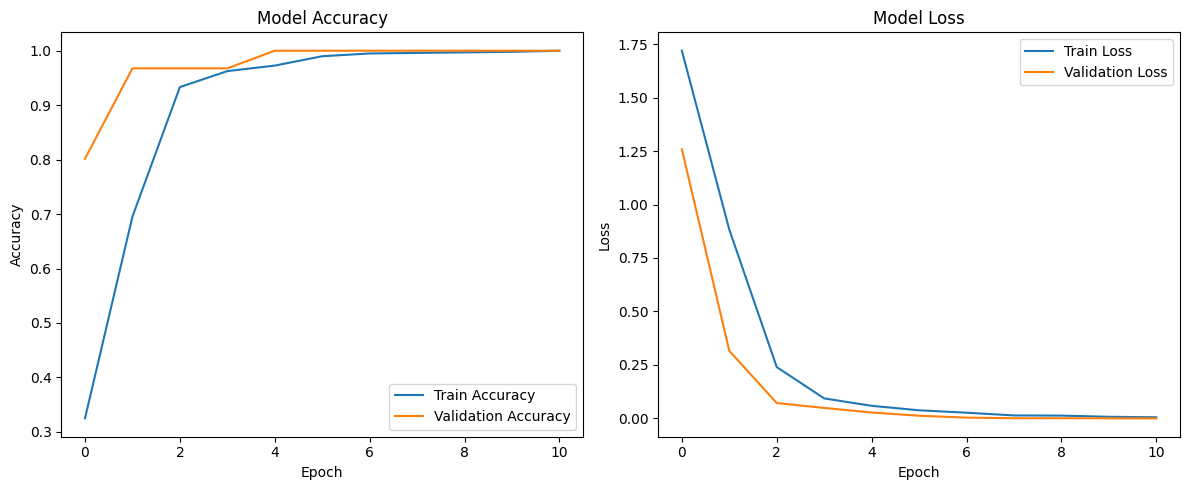

In [23]:
# Step 1: Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Step 2: Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Step 3: Show the plots
plt.tight_layout()
plt.show()

*EVALUATE MODEL PERFORMANCE*

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


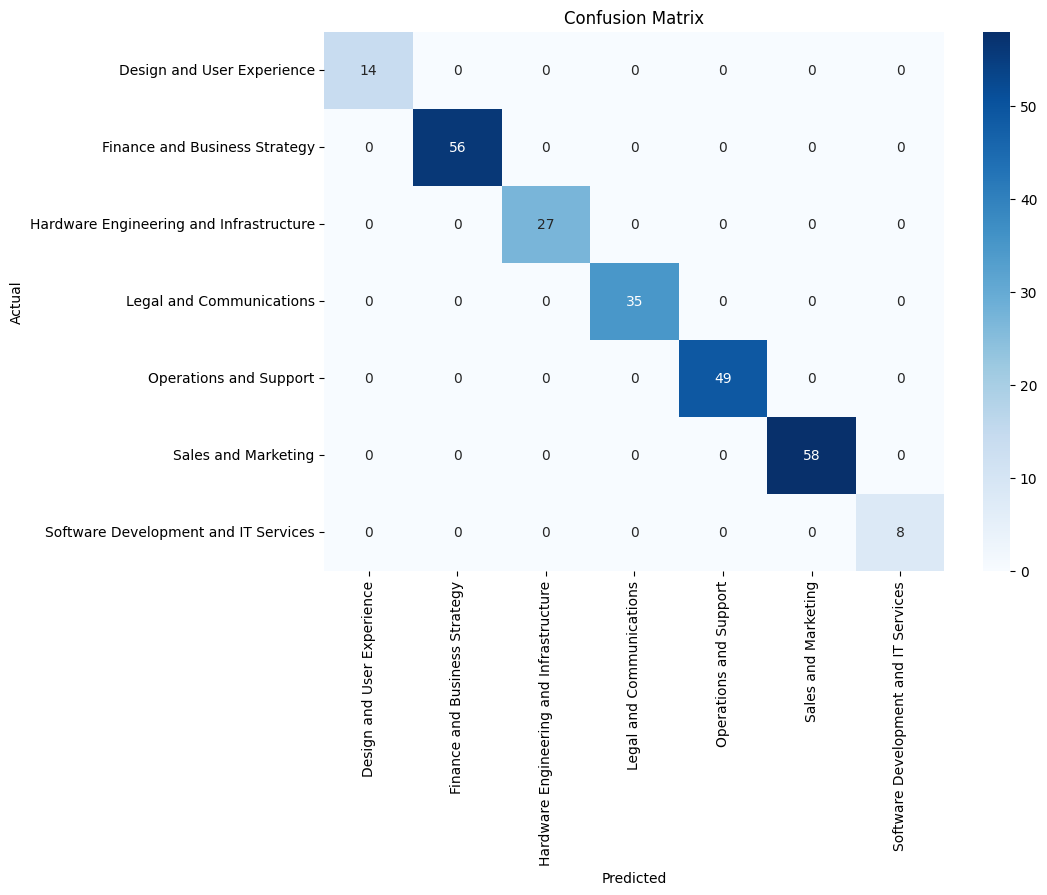

                                         precision    recall  f1-score   support

             Design and User Experience       1.00      1.00      1.00        14
          Finance and Business Strategy       1.00      1.00      1.00        56
Hardware Engineering and Infrastructure       1.00      1.00      1.00        27
               Legal and Communications       1.00      1.00      1.00        35
                 Operations and Support       1.00      1.00      1.00        49
                    Sales and Marketing       1.00      1.00      1.00        58
   Software Development and IT Services       1.00      1.00      1.00         8

                               accuracy                           1.00       247
                              macro avg       1.00      1.00      1.00       247
                           weighted avg       1.00      1.00      1.00       247



In [24]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

In [25]:
# Fungsi untuk praproses input teks
def preprocess_input_text(input_text):
    # Ubah teks menjadi huruf kecil dan hilangkan tanda baca
    input_text = input_text.lower()
    input_text = re.sub(f"[{string.punctuation}]", "", input_text)
    return input_text

# Fungsi untuk memprediksi kategori pekerjaan berdasarkan input pengguna
def predict_job_category(user_input, tfidf_vectorizer, model, label_encoder):
    # Praproses teks input pengguna
    preprocessed_text = preprocess_input_text(user_input)

    # Lakukan transformasi TF-IDF pada teks input
    text_vectorized = tfidf_vectorizer.transform([preprocessed_text])  # Input sebagai list

    # Pastikan input menjadi array 2D (shape: 1, n_features)
    text_vectorized_array = text_vectorized.toarray()  # Mengubahnya menjadi array 2D

    # Prediksi kategori menggunakan model
    y_pred = model.predict(text_vectorized_array)  # Prediksi hasil
    y_pred_classes = np.argmax(y_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi

    # Dekode hasil prediksi menjadi kategori (LabelEncoder)
    predicted_category = label_encoder.inverse_transform(y_pred_classes)[0]

    return predicted_category

In [26]:
# Alur percakapan dan pengambilan keputusan
def ask_questions():
    # print("Pertanyaan 1:")
    print("Seberapa tertarik Anda dengan ide untuk mengembangkan dan meningkatkan penjualan produk ?")
    print("1 - Tidak tertarik sama sekali")
    print("2 - Kurang tertarik")
    print("3 - Netral")
    print("4 - Tertarik")
    print("5 - Sangat tertarik")
    pertanyaan_1 = int(input("Jawaban Anda (1-5) : "))

    if pertanyaan_1 == 4 or pertanyaan_1 == 5:
        # print("\nPertanyaan 2:")
        print("Apakah Anda suka bekerja dengan orang lain dalam konteks bisnis ?")
        print("Ya")
        print("Tidak")
        pertanyaan_2 = input("Jawaban Anda (Ya/Tidak) : ").lower()

        if pertanyaan_2 == "ya":
            # print("\nPertanyaan 3:")
            print("Seberapa sering Anda berbagi ide atau strategi dengan orang lain ?")
            print("1 - Tidak pernah")
            print("2 - Jarang")
            print("3 - Kadang-kadang")
            print("4 - Sering")
            print("5 - Selalu")
            pertanyaan_3 = int(input("Jawaban Anda (1-5) : "))

            if pertanyaan_3 == 4 or pertanyaan_3 == 5:
                # print("\nPertanyaan 5:")
                print("Seberapa Anda menikmati berkolaborasi dalam proyek ?")
                print("1 - Tidak suka")
                print("2 - Kurang suka")
                print("3 - Biasa saja")
                print("4 - Suka")
                print("5 - Sangat suka")
                pertanyaan_5 = int(input("Jawaban Anda (1-5) : "))

                if pertanyaan_5 == 4 or pertanyaan_5 == 5:
                    return "works managing partners"
                else:
                    return "increase product sales"

            else:
                return "increase product sales"

        else:
            # print("\nPertanyaan 4:")
            print("Apakah Anda lebih suka bekerja secara mandiri ?")
            print("Ya")
            print("Tidak")
            pertanyaan_4 = input("Jawaban Anda (Ya/Tidak) : ").lower()

            if pertanyaan_4 == "ya":
                return "increase product sales"
            else:
                # print("\nPertanyaan 5:")
                print("Seberapa Anda menikmati berkolaborasi dalam proyek ?")
                print("1 - Tidak suka")
                print("2 - Kurang suka")
                print("3 - Biasa saja")
                print("4 - Suka")
                print("5 - Sangat suka")
                pertanyaan_5 = int(input("Jawaban Anda (1-5) : "))

                if pertanyaan_5 == 4 or pertanyaan_5 == 5:
                    return "works managing partners"
                else:
                    return "increase product sales"

    else:
        # print("\nPertanyaan 6:")
        print("Apakah Anda tertarik untuk memahami pasar teknologi bisnis ?")
        print("Ya")
        print("Tidak")
        pertanyaan_6 = input("Jawaban Anda (Ya/Tidak) : ").lower()

        if pertanyaan_6 == "ya":
            # print("\nPertanyaan 7:")
            print("Seberapa sering Anda membaca berita atau artikel tentang teknologi ?")
            print("1 - Tidak pernah")
            print("2 - Jarang")
            print("3 - Kadang-kadang")
            print("4 - Sering")
            print("5 - Selalu")
            pertanyaan_7 = int(input("Jawaban Anda (1-5) : "))

            if pertanyaan_7 == 4 or pertanyaan_7 == 5:
                # print("\nPertanyaan 9:")
                print("Seberapa Anda peduli tentang tren di pasar keuangan ?")
                print("1 - Tidak peduli")
                print("2 - Kurang peduli")
                print("3 - Biasa saja")
                print("4 - Peduli")
                print("5 - Sangat Peduli")
                pertanyaan_9 = int(input("Jawaban Anda (1-5) : "))

                if pertanyaan_9 == 4 or pertanyaan_9 == 5:
                  # print("\nPertanyaan 10:")
                  print("Apakah Anda suka mengikuti perkembangan ekonomi ?")
                  print("Ya")
                  print("Tidak")
                  pertanyaan_10 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                  if pertanyaan_10 == "ya":
                    # print("\nPertanyaan 11:")
                    print("Seberapa sering Anda mendiskusikan isu-isu keuangan dengan teman atau keluarga ?")
                    print("1 - Tidak pernah")
                    print("2 - Jarang")
                    print("3 - Kadang-kadang")
                    print("4 - Sering")
                    print("5 - Selalu")
                    pertanyaan_11 = int(input("Jawaban Anda (1-5) : "))

                    if pertanyaan_11 == 4 or pertanyaan_11 == 5:
                      return "financial market trends"
                    else:
                      return "manufacturing operation process"
                  else:
                    # print("\nPertanyaan 12:")
                    print("Apakah Anda tertarik untuk memahami proses manufaktur ?")
                    print("Ya")
                    print("Tidak")
                    pertanyaan_12 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                    if pertanyaan_12 == "ya":
                      return "manufacturing operation process"
                    else:
                      # print("\nPertanyaan 13:")
                      print("Seberapa Anda suka bekerja dengan alat dan mesin ?")
                      print("1 - Tidak suka")
                      print("2 - Kurang suka")
                      print("3 - Biasa saja")
                      print("4 - Suka")
                      print("5 - Sangat suka")
                      pertanyaan_13 = int(input("Jawaban Anda (1-5) : "))

                      if pertanyaan_13 == 4 or pertanyaan_13 == 5:
                        return "manufacturing operation process"
                      else:
                        # print("\nPertanyaan 14:")
                        print("Apakah Anda suka merancang aplikasi atau alat teknologi ?")
                        print("Ya")
                        print("Tidak")
                        pertanyaan_14 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                        if pertanyaan_14 == "ya":
                          # print("\nPertanyaan 15:")
                          print("Seberapa Anda menikmati mengembangkan aplikasi mobile ?")
                          print("1 - Tidak suka")
                          print("2 - Kurang suka")
                          print("3 - Biasa saja")
                          print("4 - Suka")
                          print("5 - Sangat suka")
                          pertanyaan_15 = int(input("Jawaban Anda (1-5) : "))

                          if pertanyaan_15 == 4 or pertanyaan_15 == 5:
                            return "mobile app development"
                          else:
                            return "architect technology applications"
                        else:
                          # print("\nPertanyaan 16:")
                          print("Apakah Anda suka berkomunikasi tentang proyek atau konsultasi ?")
                          print("Ya")
                          print("Tidak")
                          pertanyaan_16 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                          if pertanyaan_16 == "ya":
                            # print("\nPertanyaan 17:")
                            print("Seberapa sering Anda terlibat dalam diskusi proyek dengan tim ?")
                            print("1 - Tidak pernah")
                            print("2 - Jarang")
                            print("3 - Kadang-kadang")
                            print("4 - Sering")
                            print("5 - Selalu")
                            pertanyaan_17 = int(input("Jawaban Anda (1-5) : "))

                            if pertanyaan_17 == 4 or pertanyaan_17 == 5:
                              return "project consulting communication"
                            else:
                              # print("\nPertanyaan 18:")
                              print("Seberapa Anda menikmati mengumpulkan dan menganalisis informasi ?")
                              print("1 - Tidak suka")
                              print("2 - Kurang suka")
                              print("3 - Biasa saja")
                              print("4 - Suka")
                              print("5 - Sangat suka")
                              pertanyaan_18 = int(input("Jawaban Anda (1-5) : "))

                              if pertanyaan_18 == 4 or pertanyaan_18 == 5:
                                return "collect analyze data"
                              else:
                                # print("\nPertanyaan 19:")
                                print("Apakah Anda tertarik dengan proses dalam manufaktur ?")
                                print("Ya")
                                print("Tidak")
                                pertanyaan_19 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                if pertanyaan_19 == "ya":
                                  return "manufacturing operation process"
                                else:
                                  # print("\nPertanyaan 20:")
                                  print("Apakah Anda suka bekerja dengan pemasok atau vendor ?")
                                  print("Ya")
                                  print("Tidak")
                                  pertanyaan_20 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                  if pertanyaan_20 == "ya":
                                    return "suppliers operation engineering"
                                  else:
                                    # print("\nPertanyaan 21:")
                                    print("Seberapa pentingkah Anda rasa dokumentasi teknis dalam pekerjaan ?")
                                    print("1 - Tidak penting")
                                    print("2 - Kurang penting")
                                    print("3 - Biasa saja")
                                    print("4 - Penting")
                                    print("5 - Sangat penting")
                                    pertanyaan_21 = int(input("Jawaban Anda (1-5) : "))

                                    if pertanyaan_21 == 4 or pertanyaan_21 == 5:
                                      return "technical documentation design"
                                    else:
                                      # print("\nPertanyaan 22:")
                                      print("Apakah Anda suka mendesain antarmuka pengguna untuk aplikasi atau website ?")
                                      print("Ya")
                                      print("Tidak")
                                      pertanyaan_22 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                      if pertanyaan_22 == "ya":
                                        # print("\nPertanyaan 23:")
                                        print("Seberapa Anda menikmati menulis atau mengedit dokumen ?")
                                        print("1 - Tidak suka")
                                        print("2 - Kurang suka")
                                        print("3 - Biasa saja")
                                        print("4 - Suka")
                                        print("5 - Sangat suka")
                                        pertanyaan_23 = int(input("Jawaban Anda (1-5) : "))

                                        if pertanyaan_23 == 4 or pertanyaan_23 == 5:
                                          return "user interface design"
                                        else:
                                          return "write edit development"
                                      else:
                                        return "corporate communication skills"
                          else:
                            # print("\nPertanyaan 18:")
                            print("Seberapa Anda menikmati mengumpulkan dan menganalisis informasi ?")
                            print("1 - Tidak suka")
                            print("2 - Kurang suka")
                            print("3 - Biasa saja")
                            print("4 - Suka")
                            print("5 - Sangat suka")
                            pertanyaan_18 = int(input("Jawaban Anda (1-5) : "))

                            if pertanyaan_18 == 4 or pertanyaan_18 == 5:
                              return "collect analyze data"
                            else:
                              # print("\nPertanyaan 19:")
                              print("Apakah Anda tertarik dengan proses dalam manufaktur ?")
                              print("Ya")
                              print("Tidak")
                              pertanyaan_19 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                              if pertanyaan_19 == "ya":
                                return "manufacturing operation process"
                              else:
                                # print("\nPertanyaan 20:")
                                print("Apakah Anda suka bekerja dengan pemasok atau vendor ?")
                                print("Ya")
                                print("Tidak")
                                pertanyaan_20 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                if pertanyaan_20 == "ya":
                                  return "suppliers operation engineering"
                                else:
                                  # print("\nPertanyaan 21:")
                                  print("Seberapa pentingkah Anda rasa dokumentasi teknis dalam pekerjaan ?")
                                  print("1 - Tidak penting")
                                  print("2 - Kurang penting")
                                  print("3 - Biasa saja")
                                  print("4 - Penting")
                                  print("5 - Sangat penting")
                                  pertanyaan_21 = int(input("Jawaban Anda (1-5) : "))

                                  if pertanyaan_21 == 4 or pertanyaan_21 == 5:
                                    return "technical documentation design"
                                  else:
                                    # print("\nPertanyaan 22:")
                                    print("Apakah Anda suka mendesain antarmuka pengguna untuk aplikasi atau website ?")
                                    print("Ya")
                                    print("Tidak")
                                    pertanyaan_22 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                    if pertanyaan_22 == "ya":
                                      # print("\nPertanyaan 23:")
                                      print("Seberapa Anda menikmati menulis atau mengedit dokumen ?")
                                      print("1 - Tidak suka")
                                      print("2 - Kurang suka")
                                      print("3 - Biasa saja")
                                      print("4 - Suka")
                                      print("5 - Sangat suka")
                                      pertanyaan_23 = int(input("Jawaban Anda (1-5) : "))

                                      if pertanyaan_23 == 4 or pertanyaan_23 == 5:
                                        return "user interface design"
                                      else:
                                        return "write edit development"
                                    else:
                                      return "corporate communication skills"
                else:
                  return "manufacturing operation process"
            else:
                return "business technology market"
        else:
            # print("\nPertanyaan 8:")
            print("Apakah Anda tertarik untuk belajar tentang bisnis dan teknologi ?")
            print("Ya")
            print("Tidak")
            pertanyaan_8 = input("Jawaban Anda (Ya/Tidak) : ").lower()

            if pertanyaan_8 == "ya":
              return "business technology market"
            else:
              # print("\nPertanyaan 9:")
              print("Seberapa Anda peduli tentang tren di pasar keuangan ?")
              print("1 - Tidak peduli")
              print("2 - Kurang peduli")
              print("3 - Biasa saja")
              print("4 - Peduli")
              print("5 - Sangat Peduli")
              pertanyaan_9 = int(input("Jawaban Anda (1-5) : "))

              if pertanyaan_9 == 4 or pertanyaan_9 == 5:
                # print("\nPertanyaan 10:")
                print("Apakah Anda suka mengikuti perkembangan ekonomi ?")
                print("Ya")
                print("Tidak")
                pertanyaan_10 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                if pertanyaan_10 == "ya":
                  # print("\nPertanyaan 11:")
                  print("Seberapa sering Anda mendiskusikan isu-isu keuangan dengan teman atau keluarga ?")
                  print("1 - Tidak pernah")
                  print("2 - Jarang")
                  print("3 - Kadang-kadang")
                  print("4 - Sering")
                  print("5 - Selalu")
                  pertanyaan_11 = int(input("Jawaban Anda (1-5) : "))

                  if pertanyaan_11 == 4 or pertanyaan_11 == 5:
                    return "financial market trends"
                  else:
                    return "manufacturing operation process"
                else:
                  # print("\nPertanyaan 12:")
                  print("Apakah Anda tertarik untuk memahami proses manufaktur ?")
                  print("Ya")
                  print("Tidak")
                  pertanyaan_12 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                  if pertanyaan_12 == "ya":
                    return "manufacturing operation process"
                  else:
                    # print("\nPertanyaan 13:")
                    print("Seberapa Anda suka bekerja dengan alat dan mesin ?")
                    print("1 - Tidak suka")
                    print("2 - Kurang suka")
                    print("3 - Biasa saja")
                    print("4 - Suka")
                    print("5 - Sangat suka")
                    pertanyaan_13 = int(input("Jawaban Anda (1-5) : "))

                    if pertanyaan_13 == 4 or pertanyaan_13 == 5:
                      return "manufacturing operation process"
                    else:
                      # print("\nPertanyaan 14:")
                      print("Apakah Anda suka merancang aplikasi atau alat teknologi ?")
                      print("Ya")
                      print("Tidak")
                      pertanyaan_14 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                      if pertanyaan_14 == "ya":
                        # print("\nPertanyaan 15:")
                        print("Seberapa Anda menikmati mengembangkan aplikasi mobile ?")
                        print("1 - Tidak suka")
                        print("2 - Kurang suka")
                        print("3 - Biasa saja")
                        print("4 - Suka")
                        print("5 - Sangat suka")
                        pertanyaan_15 = int(input("Jawaban Anda (1-5) : "))

                        if pertanyaan_15 == 4 or pertanyaan_15 == 5:
                          return "mobile app development"
                        else:
                          return "architect technology applications"
                      else:
                        # print("\nPertanyaan 16:")
                        print("Apakah Anda suka berkomunikasi tentang proyek atau konsultasi ?")
                        print("Ya")
                        print("Tidak")
                        pertanyaan_16 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                        if pertanyaan_16 == "ya":
                          # print("\nPertanyaan 17:")
                          print("Seberapa sering Anda terlibat dalam diskusi proyek dengan tim ?")
                          print("1 - Tidak pernah")
                          print("2 - Jarang")
                          print("3 - Kadang-kadang")
                          print("4 - Sering")
                          print("5 - Selalu")
                          pertanyaan_17 = int(input("Jawaban Anda (1-5) : "))

                          if pertanyaan_17 == 4 or pertanyaan_17 == 5:
                            return "project consulting communication"
                          else:
                            # print("\nPertanyaan 18:")
                            print("Seberapa Anda menikmati mengumpulkan dan menganalisis informasi ?")
                            print("1 - Tidak suka")
                            print("2 - Kurang suka")
                            print("3 - Biasa saja")
                            print("4 - Suka")
                            print("5 - Sangat suka")
                            pertanyaan_18 = int(input("Jawaban Anda (1-5) : "))

                            if pertanyaan_18 == 4 or pertanyaan_18 == 5:
                              return "collect analyze data"
                            else:
                              # print("\nPertanyaan 19:")
                              print("Apakah Anda tertarik dengan proses dalam manufaktur ?")
                              print("Ya")
                              print("Tidak")
                              pertanyaan_19 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                              if pertanyaan_19 == "ya":
                                return "manufacturing operation process"
                              else:
                                # print("\nPertanyaan 20:")
                                print("Apakah Anda suka bekerja dengan pemasok atau vendor ?")
                                print("Ya")
                                print("Tidak")
                                pertanyaan_20 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                if pertanyaan_20 == "ya":
                                  return "suppliers operation engineering"
                                else:
                                  # print("\nPertanyaan 21:")
                                  print("Seberapa pentingkah Anda rasa dokumentasi teknis dalam pekerjaan ?")
                                  print("1 - Tidak penting")
                                  print("2 - Kurang penting")
                                  print("3 - Biasa saja")
                                  print("4 - Penting")
                                  print("5 - Sangat penting")
                                  pertanyaan_21 = int(input("Jawaban Anda (1-5) : "))

                                  if pertanyaan_21 == 4 or pertanyaan_21 == 5:
                                    return "technical documentation design"
                                  else:
                                    # print("\nPertanyaan 22:")
                                    print("Apakah Anda suka mendesain antarmuka pengguna untuk aplikasi atau website ?")
                                    print("Ya")
                                    print("Tidak")
                                    pertanyaan_22 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                    if pertanyaan_22 == "ya":
                                      # print("\nPertanyaan 23:")
                                      print("Seberapa Anda menikmati menulis atau mengedit dokumen ?")
                                      print("1 - Tidak suka")
                                      print("2 - Kurang suka")
                                      print("3 - Biasa saja")
                                      print("4 - Suka")
                                      print("5 - Sangat suka")
                                      pertanyaan_23 = int(input("Jawaban Anda (1-5) : "))

                                      if pertanyaan_23 == 4 or pertanyaan_23 == 5:
                                        return "user interface design"
                                      else:
                                        return "write edit development"
                                    else:
                                      return "corporate communication skills"
                        else:
                          # print("\nPertanyaan 18:")
                          print("Seberapa Anda menikmati mengumpulkan dan menganalisis informasi ?")
                          print("1 - Tidak suka")
                          print("2 - Kurang suka")
                          print("3 - Biasa saja")
                          print("4 - Suka")
                          print("5 - Sangat suka")
                          pertanyaan_18 = int(input("Jawaban Anda (1-5) : "))

                          if pertanyaan_18 == 4 or pertanyaan_18 == 5:
                            return "collect analyze data"
                          else:
                            # print("\nPertanyaan 19:")
                            print("Apakah Anda tertarik dengan proses dalam manufaktur ?")
                            print("Ya")
                            print("Tidak")
                            pertanyaan_19 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                            if pertanyaan_19 == "ya":
                              return "manufacturing operation process"
                            else:
                              # print("\nPertanyaan 20:")
                              print("Apakah Anda suka bekerja dengan pemasok atau vendor ?")
                              print("Ya")
                              print("Tidak")
                              pertanyaan_20 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                              if pertanyaan_20 == "ya":
                                return "suppliers operation engineering"
                              else:
                                # print("\nPertanyaan 21:")
                                print("Seberapa pentingkah Anda rasa dokumentasi teknis dalam pekerjaan ?")
                                print("1 - Tidak penting")
                                print("2 - Kurang penting")
                                print("3 - Biasa saja")
                                print("4 - Penting")
                                print("5 - Sangat penting")
                                pertanyaan_21 = int(input("Jawaban Anda (1-5) : "))

                                if pertanyaan_21 == 4 or pertanyaan_21 == 5:
                                  return "technical documentation design"
                                else:
                                  # print("\nPertanyaan 22:")
                                  print("Apakah Anda suka mendesain antarmuka pengguna untuk aplikasi atau website ?")
                                  print("Ya")
                                  print("Tidak")
                                  pertanyaan_22 = input("Jawaban Anda (Ya/Tidak) : ").lower()

                                  if pertanyaan_22 == "ya":
                                    # print("\nPertanyaan 23:")
                                    print("Seberapa Anda menikmati menulis atau mengedit dokumen ?")
                                    print("1 - Tidak suka")
                                    print("2 - Kurang suka")
                                    print("3 - Biasa saja")
                                    print("4 - Suka")
                                    print("5 - Sangat suka")
                                    pertanyaan_23 = int(input("Jawaban Anda (1-5) : "))

                                    if pertanyaan_23 == 4 or pertanyaan_23 == 5:
                                      return "user interface design"
                                    else:
                                      return "write edit development"
                                  else:
                                    return "corporate communication skills"
              else:
                return "manufacturing operation process"


# Fungsi utama
def main():
    print("Selamat datang di aplikasi Job Recommendation!")
    user_category = ask_questions()
    print(f"\nKategori pekerjaan yang disarankan berdasarkan jawaban Anda: {user_category}")

    # Simulasi input pengguna untuk prediksi kategori pekerjaan
    user_input = user_category  # Kategori yang sudah dipilih
    predicted_category = predict_job_category(
        user_input,
        tfidf_vectorizer,  # TF-IDF Vectorizer yang sudah dilatih
        model,             # Model yang sudah Anda latih
        label_encoder      # LabelEncoder yang sudah dilatih
    )

    print(f"Rekomendasi pekerjaan: {predicted_category}")

if __name__ == "__main__":
    main()

Selamat datang di aplikasi Job Recommendation!
Seberapa tertarik Anda dengan ide untuk mengembangkan dan meningkatkan penjualan produk ?
1 - Tidak tertarik sama sekali
2 - Kurang tertarik
3 - Netral
4 - Tertarik
5 - Sangat tertarik
Jawaban Anda (1-5) : 4
Apakah Anda suka bekerja dengan orang lain dalam konteks bisnis ?
Ya
Tidak
Jawaban Anda (Ya/Tidak) : tidak
Apakah Anda lebih suka bekerja secara mandiri ?
Ya
Tidak
Jawaban Anda (Ya/Tidak) : tidak
Seberapa Anda menikmati berkolaborasi dalam proyek ?
1 - Tidak suka
2 - Kurang suka
3 - Biasa saja
4 - Suka
5 - Sangat suka
Jawaban Anda (1-5) : 4

Kategori pekerjaan yang disarankan berdasarkan jawaban Anda: works managing partners
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Rekomendasi pekerjaan: Sales and Marketing
